# Reading Data:

In [1]:
import pandas as pd

def read_file(file_path: str) -> pd.DataFrame:
    """
    Reads a CSV file through a given file path.
    """
    return pd.read_csv(file_path)

job_change_df_cleaned = read_file('job_change_df_cleaned.csv')

/var/folders/jq/xzwg3k5d0nqb3574ynkvzc740000gn/T/ipykernel_69205/2661726985.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Visualization #1 — Heatmap:

First, let's visualize the data through a heatmap, to determine the features we should include in the model.

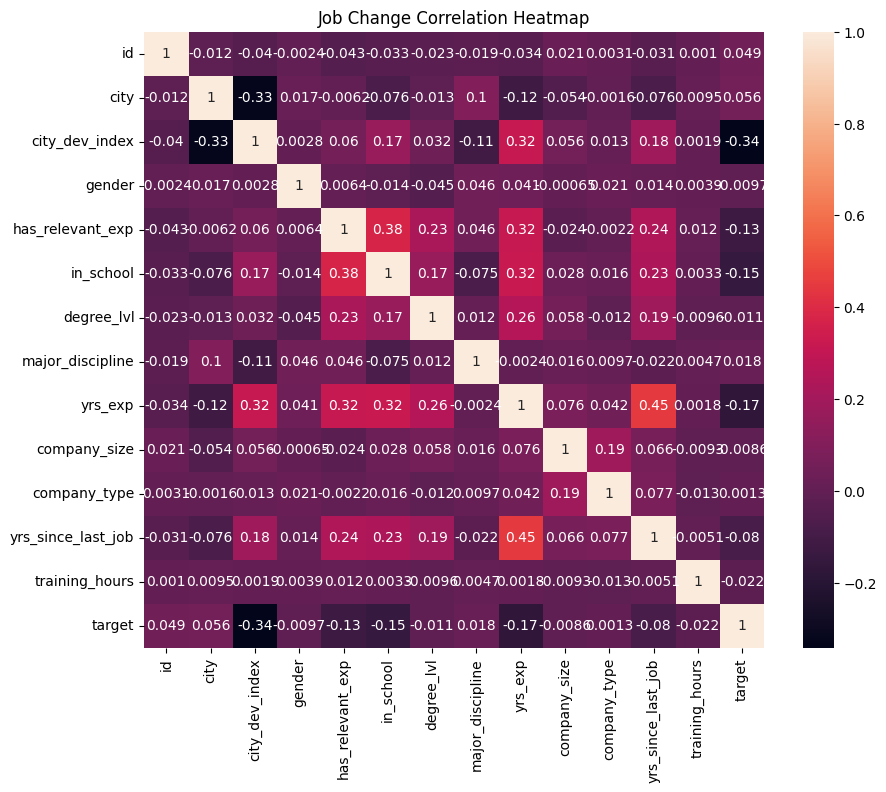

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_heatmap(df: pd.DataFrame) -> None:
    """
    Creates a heatmap of a given DataFrame.
    """
    plt.figure(figsize = (10, 8))
    sns.heatmap(df.corr(), annot = True)
    plt.title('Job Change Correlation Heatmap')
    plt.show()

create_heatmap(job_change_df_cleaned)

As the heatmap illustrates, the top features most correlated with our target are, in order, "City Development Index", "Years of Experience", "In School", and "Has Relevant Experience". The fifth most correlated feature is "Years Since Last Job", though this bears a striking multicollinearity with "Years of Experience", rather intuitively: people who've had invested a long time at their current company, since their last job, necessarily increased their net experience in doing so. As such, we'll exclude the "Years Since Last Job" feature and its measly 8.2% correlation in our models.

The preceding features of "City" and "ID" don't warrant inclusion, either, bearing the highest correlations among the remaining features, though multicollinear (City, with City Index) and confounding (ID) as they are. Given these two are incredibly flawed in their respective ways and yet predict the target best among the remaining columns, I believe cutting off our model's input at "Has Relevant Experience" would be most appropriate, to prevent overfitting.

# Visualization #2 — Box and Whisker Plots:

Next, let's create Box and Whisker Plots for those top four features, to determine generally if their data have any nasty skews or imbalances, which we'll confirm through histograms to come.

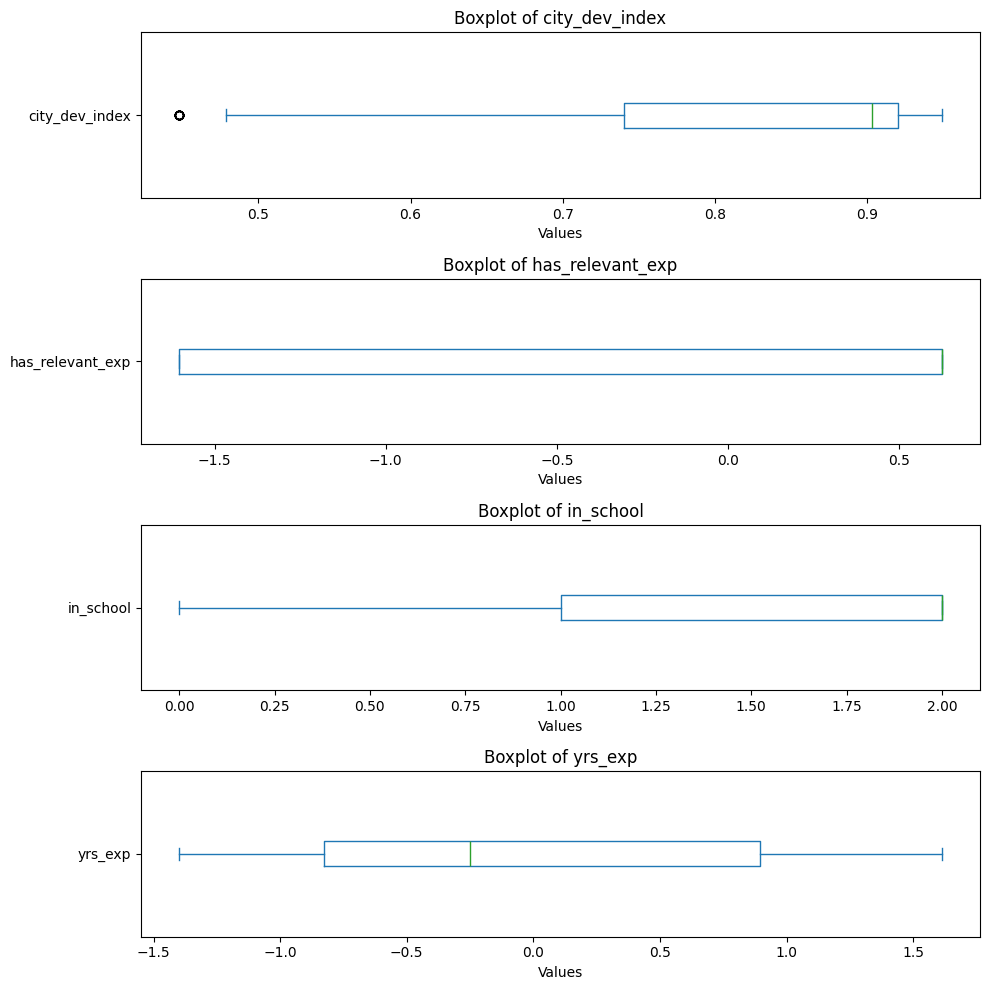

In [3]:
def create_boxplots(df: pd.DataFrame, columns: list[str], figsize: tuple[int, int] = None) -> None:
    """
    Creates box plots for specified columns in a given DataFrame.
    """
    fig, axes = plt.subplots(nrows = len(columns), figsize = figsize)
    
    for i, column in enumerate(columns):
        ax = axes[i]
        df[column].plot(kind = 'box', ax = ax, vert = False)
        ax.set(title = f'Boxplot of {column}', xlabel = 'Values')
    
    plt.tight_layout()
    plt.show()

create_boxplots(job_change_df_cleaned, ["city_dev_index", "has_relevant_exp", "in_school", "yrs_exp"], [10, 10])

The two features which jump out as potentially disproportionate are "Has Relevant Experience" and "In School", whose medians (green line) are plastered against the right side of their plots. Moreover, the quartile cutoffs of "Has Relevant Experience" fill the entire graph, indicating a bimodal distribution with a much greater number of positive than negative points, tracking with the column's two variables we encoded in preprocessing. The box plot of "In School" illustrates similar properties, however its first quartile cutoff rests exactly in the middle of the graph, tracking with a similar narrative of disproportionate positive-to-negative data, whose plot is modified by the existence of a "middle" or "neutral" data type, also tracking with the three variables we encoded for the column, in preprocessing.

The features of "Years of Experience" and "City Development Index" don't bear such patterns—and are thus healthy—for different reasons. For the former, the box plot displays a strikiingly Gaussian form—a normal distribution—indicating that no one data value overpowers another: no stratification will be necessary! The box plot of "City Development Index" presents a less idyllic picture, but a perfectly adeuqate one yet. Although the skew is certainly negative, much like our troublemakers, the considerable offset of this plot's quartile range from its positive outlier cutoff, and expansive outlier cutoff range describe a feature whose stratification would harm our model more than its raw input, especially for our highest-correlation metric. Again, we're looking for extreme imbalances because being too liberal with stratification could easily wound our models' accuracy.

# Visualization #3 — Bar Graphs:

Then, let's validate or reject the imbalances of "Has Relevant Experience" and "In School" through histogram visualization of the features' value counts.

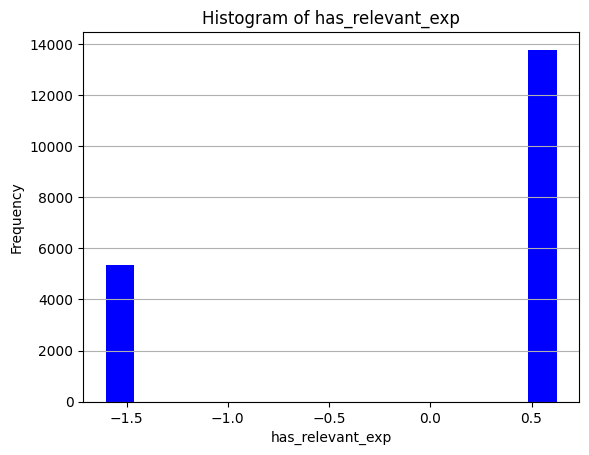

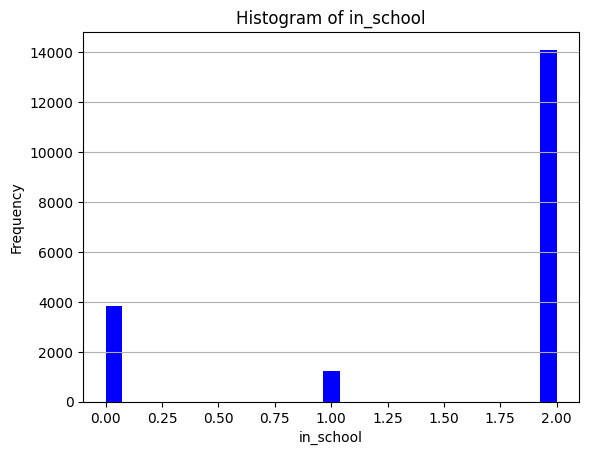

In [4]:
def create_histogram(df: pd.DataFrame, columns: list):
    """
    Create histograms for each specified column in a given DataFrame.
    """
    for column_name in columns:
        plt.hist(df[column_name], bins='auto', color='blue')
        plt.grid(axis='y')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {column_name}')
        plt.show()

columns_to_plot = ["has_relevant_exp", "in_school"]
create_histogram(job_change_df_cleaned, columns_to_plot)

The "Has Relevant Experience" histogram reveals there are 2/5 the count of low-relevant-experience data scientists to those with high relevant experience, indicating the stratification of this column is in all likelihood unecessary and would harm our models more than benefit them. The histogram of "In School", however, reveals a more dramatic imbalance, validating our findings in the box plot visualization. Still, it's unclear whether the column's imbalance will appreciably impact model performance, and as such our first Logistic Regression model will simply sample our chosen four features without stratification of "In School".

# Model #1A — Logistic Regression ("In School" Unstratified):

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def logistic_regression_model(df: pd.DataFrame, features: list[str], target: str) -> None:
    """
    Trains a logistic regression model on specified features from a given dataframe,
    then returns the model's ROC AUC score.
    """
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.23, random_state = 42)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred_probability = model.predict_proba(X_test)[:, 1]
    roc_score = roc_auc_score(y_test, y_pred_probability)
    print("ROC AUC Score:", roc_score)

features = ["city_dev_index", "has_relevant_exp", "yrs_exp", "in_school"]
target = "target"

logistic_regression_model(job_change_df_cleaned, features, target)

ROC AUC Score: 0.7100015028059691


As the score illustrates, our model accuracy rests around 71%.

# Model #1B — Logistic Regression ("In School" Stratified):

Our second function, however, will stratify "In School", to see how the tune-up impacts performance. To hold the models apples-to-apples, however, "improved_logistic_regression_model" will remain exactly the same, otherwise (including the same random state!)

In [6]:
def improved_logistic_regression_model(df: pd.DataFrame, features: list[str], target: str, stratify_column: str) -> None:
    """
    Trains a logistic regression model on specified features from a given dataframe
    with one, stated column stratified, then returns the model's ROC AUC score.
    """
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.23, random_state = 42,
                                                        stratify = df[stratify_column])
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_score = roc_auc_score(y_test, y_pred_proba)
    print("ROC AUC Score:", roc_score)

stratify_column = "in_school"

improved_logistic_regression_model(job_change_df_cleaned, features, target, stratify_column)

ROC AUC Score: 0.7204853770809164


Our Logistic Regression model's performance slightly improved; it seems that its predictive abilities benefited slightly from balancing the data representation—inputs—of the "In School" feature, as well as increasing the test_size to 0.23, which is where the benefit of tuning up this metric capped out.

Still, an ROC AUC score of 71.3% is much lower accuracy than I'd prefer to substantiate a conclusion, so let's employ a Gradient Boosting Classifier to reach higher echelons of accuracy. This model will, as learned in class, take as input the data of our specified features in the dataframe, train a model to predict our target, and contribute its predictive power to our final model, at which point it will "hand off" the data to the next model, which will do exactly the same, with, ideally, better predictive capacities towards a specific side of the data than its predecessor, and the process will unfold, exactly as before. Our final model should be more accurate, by these aggregate, predictive abilities, than the simpler Logistic Regression model.

# Model #2 — Gradient Boosting Classifier:

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

def gradient_boosting_model(df: pd.DataFrame, features: list[str], target: str) -> None:
    """
    Trains a gradient boosting model on specified features from a given dataframe,
    then returns the model's ROC AUC score.
    """
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.23, random_state = 42, stratify = y)

    model = GradientBoostingClassifier(random_state = 42)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print("ROC AUC Score:", auc_score)

gradient_boosting_model(job_change_df_cleaned, features, target)

ROC AUC Score: 0.7693551519299175


As can be seen above, this model took as input the exact same features as our Logistic Regression model, but bears a nearly 6% higher ROC AUC score than the unstratified—first—model, and a 5.6% bump on the stratfied—second. To tune the GBC model's accuracy and provide a common base on which to evaluate it against the logistic regression model most fairly, I so too tuned up its test size to 0.23.

# Conclusion:
Because all three datasets predicted whether or not a data scientist was looking to change their job with accuracies—ROC AUC scores—of greater than the established benchmark of 66.6%, (in fact, they ranged between 71 - 76.9%), we reject the null that for the dataset, there exists no difference in the population characteristics between the data scientists who look for a job change and those who do not look for a job change.

This is rather intuitive, if we only return to the heatmap, our first visualization of the data. Given our top four features bore negative correlations with the target, respectively, of between 0.17 and 0.34, it was telling early-on there was some pattern threading through the dataset which could be harnessed to predict whether data scientists would pursue career changes. 

The most striking—and greatest—of these correlations is the city development index, featuring that aforementioned -0.34 correlation, which would've been far from my first guess for the preliminary predictor. On further thought, however, the metric is largely intuitive. As data scientists have flocked to emerging hubs such as San Fransisco, Seattle, New York, and Raleigh to pursue the cities' burgeoning job market for software, they tend to add value and enrich the resources of these places, improving their index score. The higher these cities' index score, the lower the probability their data scientist residents will wish to flee the mushrooming innovation around them. Such innovation could very well come from the curricula of universities and education in the area; so to speak, every course, such as this one, is the root of dozens of interactions, projects, and careers in data science.